In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img


In [ ]:
#LOAD IMAGES DATASET

def load_images_from_folder(folder_path, image_size=(128, 128)):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.png'):
            img = load_img(os.path.join(folder_path, filename), color_mode='grayscale', target_size=image_size)
            img = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img)
    return np.array(images)

# Load training data
train_noisy = load_images_from_folder('train')
train_clean = load_images_from_folder('train_cleaned')

# Load testing data
test_noisy = load_images_from_folder('test')

# Shape check
print(f'Train Noisy Shape: {train_noisy.shape}')
print(f'Train Clean Shape: {train_clean.shape}')
print(f'Test Noisy Shape: {test_noisy.shape}')


Train Noisy Shape: (144, 128, 128, 1)
Train Clean Shape: (144, 128, 128, 1)
Test Noisy Shape: (72, 128, 128, 1)


In [ ]:
# Shape check
print(f'Train Noisy Shape: {train_noisy.shape}')
print(f'Train Clean Shape: {train_clean.shape}')
print(f'Test Noisy Shape: {test_noisy.shape}')

Train Noisy Shape: (144, 128, 128, 1)
Train Clean Shape: (144, 128, 128, 1)
Test Noisy Shape: (72, 128, 128, 1)


In [ ]:
# Step 1: Check original image sizes
def get_different_sizes(folder_path):
    sizes = set()
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.png'):
            path = os.path.join(folder_path, filename)
            img = plt.imread(path)
            sizes.add(img.shape)
    return sizes

print("Original image sizes:")
print("Train:", get_different_sizes('train'))
print("Train Cleaned:", get_different_sizes('train_cleaned'))
print("Test:", get_different_sizes('test'))

# Step 2: Load and preprocess images
def load_images_from_folder(folder_path, image_size=(128, 128)):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.png'):
            img = load_img(os.path.join(folder_path, filename), color_mode='grayscale', target_size=image_size)
            img = img_to_array(img) / 255.0
            images.append(img)
    return np.array(images)

train_images = load_images_from_folder('train')
train_cleaned_images= load_images_from_folder('train_cleaned')
test_images = load_images_from_folder('test')

print(f"Train Noisy Shape: {train_noisy.shape}")
print(f"Train Clean Shape: {train_clean.shape}")
print(f"Test Noisy Shape: {test_noisy.shape}")



Original image sizes:
Train: {(420, 540), (258, 540)}
Train Cleaned: {(420, 540), (258, 540)}
Test: {(420, 540), (258, 540)}
Train Noisy Shape: (144, 128, 128, 1)
Train Clean Shape: (144, 128, 128, 1)
Test Noisy Shape: (72, 128, 128, 1)


In [ ]:
# Collect image paths
train_images = sorted([os.path.join('train', fname) for fname in os.listdir('train') if fname.endswith('.png')])
train_cleaned_images = sorted([os.path.join('train_cleaned', fname) for fname in os.listdir('train_cleaned') if fname.endswith('.png')])
test_images = sorted([os.path.join('test', fname) for fname in os.listdir('test') if fname.endswith('.png')])


In [ ]:
small_size = (258, 540)
big_size = (420, 540)

def count_images(images, small_size, big_size):
    count_small, count_big = 0, 0

    for image in images:
        img = plt.imread(image)
        if img.shape == small_size:
            count_small += 1
        elif img.shape == big_size:
            count_big += 1
    return count_small, count_big

X_train_counts = count_images(train_images, small_size, big_size)
y_train_counts = count_images(train_cleaned_images, small_size, big_size)
X_test_counts = count_images(test_images, small_size, big_size)

column_names = ['small_img', 'big_img']
row_labels = ['X_train', 'y_train', 'X_test']

counts_matrix = [X_train_counts, y_train_counts, X_test_counts]

df = pd.DataFrame(counts_matrix, columns=column_names, index=row_labels)
df


small_img  big_img
X_train         48       96
y_train         48       96
X_test          24       48

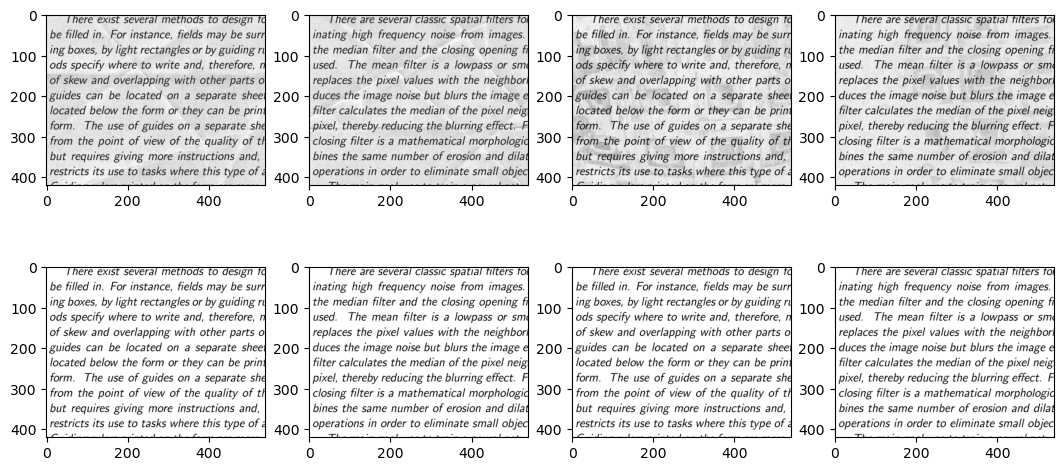

In [ ]:
#VISUALISATION of original images
fig, ax = plt.subplots(2, 4, figsize=(13, 6))

for i in range(4):
    img = plt.imread(train_images[i])
    ax[0, i].imshow(img, cmap='gray')

for i in range(4):
    img = plt.imread(train_cleaned_images[i])
    ax[1, i].imshow(img, cmap='gray')

plt.show()

In [ ]:
train_images.sort() == train_cleaned_images.sort()

True

In [ ]:

# Define function to split and save images
def split_and_save_images(images, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for image in images:
        img = plt.imread(image)
        if img.shape == (420, 540):
            # Split vertically into two (top and bottom)
            img1 = img[0:258, :]
            img2 = img[-258:, :]

            filename = os.path.basename(image).split('.')[0]
            filename1 = filename + '_1.png'
            filename2 = filename + '_2.png'

            plt.imsave(os.path.join(output_folder, filename1), img1, cmap='gray')
            plt.imsave(os.path.join(output_folder, filename2), img2, cmap='gray')
        else:
            # Already small, just save as is
            filename = os.path.basename(image)
            plt.imsave(os.path.join(output_folder, filename), img, cmap='gray')

split_and_save_images(train_images, 'train_resized')
split_and_save_images(train_cleaned_images, 'train_cleaned_resized')
split_and_save_images(test_images, 'test_resized')


In [ ]:
# Checking again image sizes after bringing all to same size
def get_different_sizes(folder_path):
    sizes = set()
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.png'):
            path = os.path.join(folder_path, filename)
            img = plt.imread(path)
            sizes.add(img.shape)
    return sizes

print("Original image sizes:")
print("Train:", get_different_sizes('train_resized'))
print("Train Cleaned:", get_different_sizes('train_cleaned_resized'))
print("Test:", get_different_sizes('test_resized'))




Original image sizes:
Train: {(258, 540, 4)}
Train Cleaned: {(258, 540, 4)}
Test: {(258, 540, 4)}


In [ ]:
train_images_resized = [os.path.join('train_resized', image) for image in os.listdir('train_resized')]
test_images_resized = [os.path.join('test_resized', image) for image in os.listdir('test_resized')]
tran_cleaned_images_resized = [os.path.join('train_cleaned_resized', image) for image in os.listdir('train_cleaned_resized')]

In [ ]:
train_images_resized.sort() == tran_cleaned_images_resized.sort() #checking if they are same

True

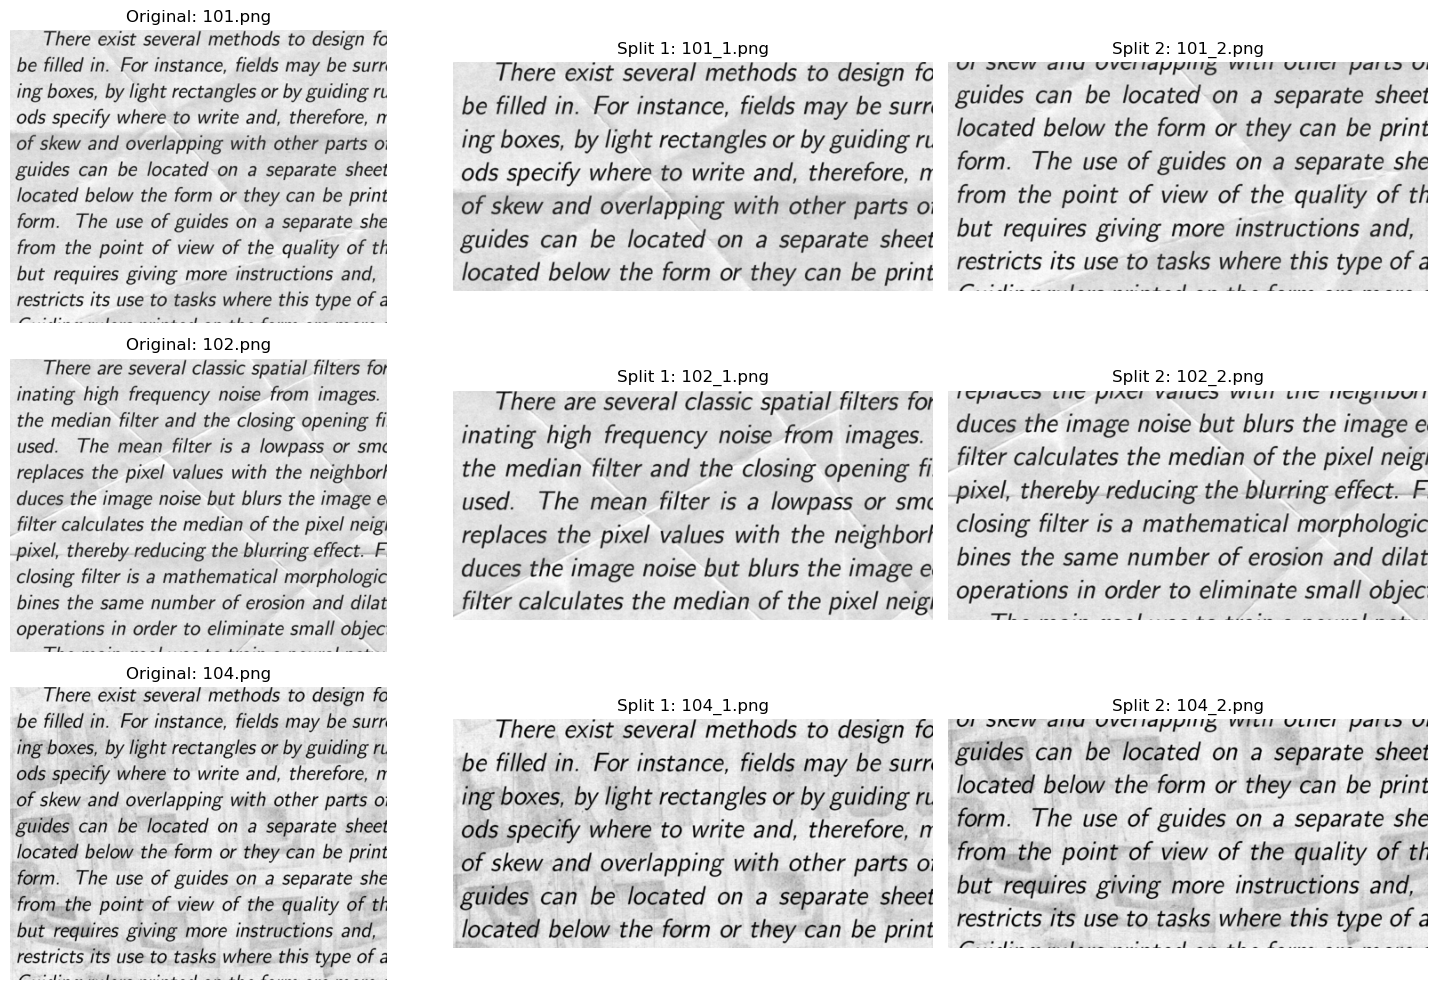

In [ ]:
#split plot

def display_original_and_split_images(original_images, num_images=3):
    plt.figure(figsize=(15, 10))

    for i in range(min(num_images, len(original_images))):
        original_path = original_images[i]
        original_img = plt.imread(original_path)

        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_img, cmap='gray')
        plt.title(f'Original: {os.path.basename(original_path)}')
        plt.axis('off')

        filename = os.path.basename(original_path).split('.')[0]
        split_img1_path = os.path.join('train_resized', filename + '_1.png')
        split_img2_path = os.path.join('train_resized', filename + '_2.png')

        if os.path.exists(split_img1_path):
            split_img1 = plt.imread(split_img1_path)
            plt.subplot(num_images, 3, i * 3 + 2)
            plt.imshow(split_img1, cmap='gray')
            plt.title(f'Split 1: {filename}_1.png')
            plt.axis('off')

        if os.path.exists(split_img2_path):
            split_img2 = plt.imread(split_img2_path)
            plt.subplot(num_images, 3, i * 3 + 3)
            plt.imshow(split_img2, cmap='gray')
            plt.title(f'Split 2: {filename}_2.png')
            plt.axis('off')

    plt.tight_layout()
    plt.show()


display_original_and_split_images(train_images, num_images=3)


In [ ]:
train_images = sorted([
    os.path.join('train', fname)
    for fname in os.listdir('train') if fname.endswith('.png')
])

(258, 540, 4)

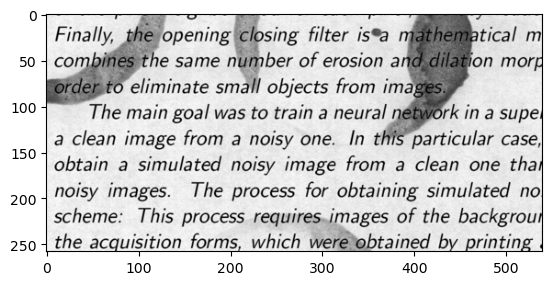

In [ ]:
image_path = train_images_resized[100]
img = plt.imread(image_path)
plt.imshow(img, cmap='gray')
img.shape

(240, 258, 540, 1)
(120, 258, 540, 1)
(240, 258, 540, 1)


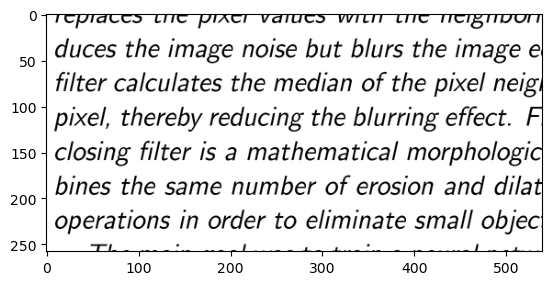

In [ ]:
def process_images(image_paths):
    image_array = np.empty((len(image_paths), 258, 540, 1), dtype=np.float32)

    for i, image_path in enumerate(image_paths):
        img = plt.imread(image_path)

        if img.shape[-1] == 4:
            img = img[..., :3]

        if len(img.shape) == 2:  # Check if the image is already grayscale
            gray_img = img[..., np.newaxis]  # Add a new axis to make it (height, width, 1)
        else:
            gray_img = np.mean(img, axis=2, keepdims=True)  # Convert the image to grayscale

        plt.imshow(gray_img[:, :, 0], cmap='gray')
#         print(gray_img.shape)

        image_array[i] = gray_img
    return image_array

# Process train_images
train_array = process_images(train_images_resized)
print(train_array.shape)

# Process test_images
test_array = process_images(test_images_resized)
print(test_array.shape)

# Process cleaned_images
clean_array = process_images(tran_cleaned_images_resized)
print(clean_array.shape)

In [ ]:
X_train = train_array
X_test = test_array
y_train = clean_array

X_train.shape, X_test.shape, y_train.shape

((240, 258, 540, 1), (120, 258, 540, 1), (240, 258, 540, 1))

In [ ]:
X_train.shape, X_test.shape, y_train.shape

((240, 258, 540, 1), (120, 258, 540, 1), (240, 258, 540, 1))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import EarlyStopping

In [ ]:
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - loss: 0.1919 - root_mean_squared_error: 0.4372 - ssim: 0.2463 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2526 - val_ssim: 0.2221
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 0.0808 - root_mean_squared_error: 0.2843 - ssim: 0.3298 - val_loss: 0.0731 - val_root_mean_squared_error: 0.2704 - val_ssim: 0.4239
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - loss: 0.0859 - root_mean_squared_error: 0.2931 - ssim: 0.4032 - val_loss: 0.0634 - val_root_mean_squared_error: 0.2517 - val_ssim: 0.4058
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 0.0682 - root_mean_squared_error: 0.2611 - ssim: 0.3488 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2291 - val_ssim: 0.4663
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 0.0566 - root_mean_squared_error: 0.2378 - ssim: 0.4825 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2036 - val_ssim: 0.5693
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - loss: 0.0

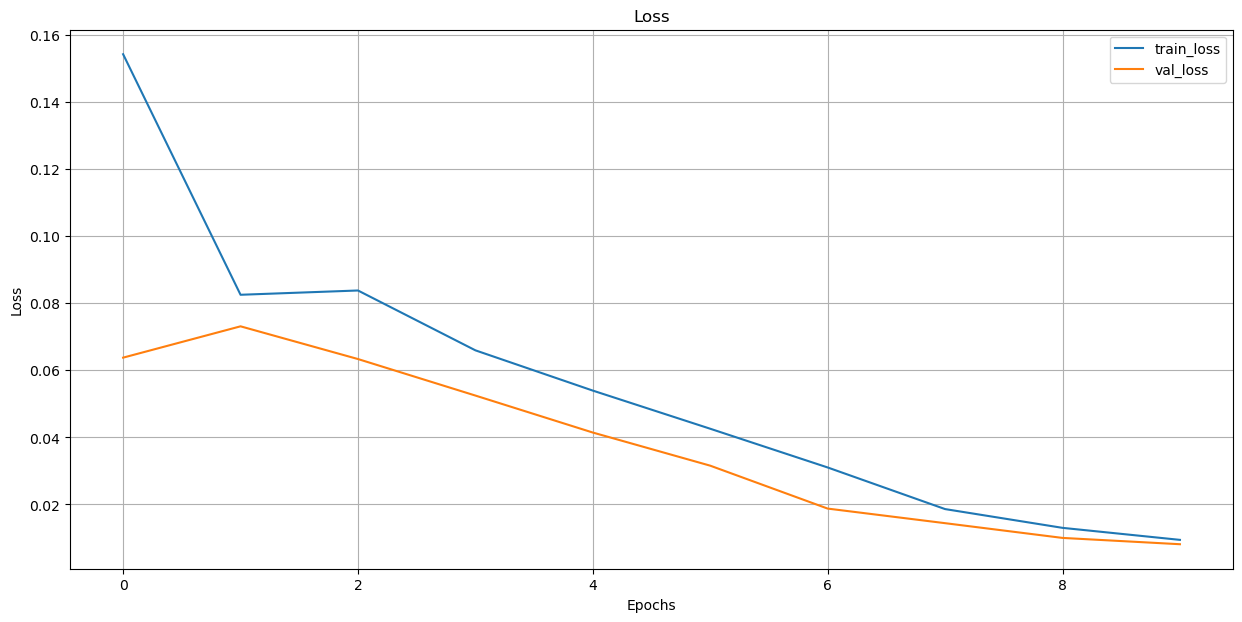

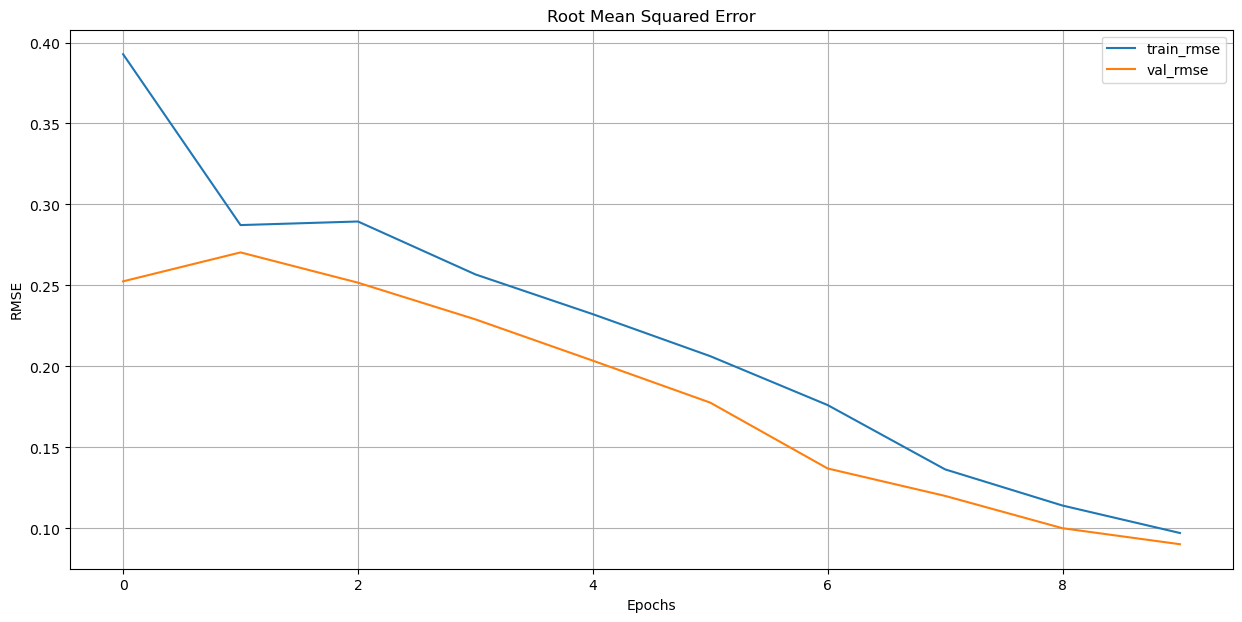

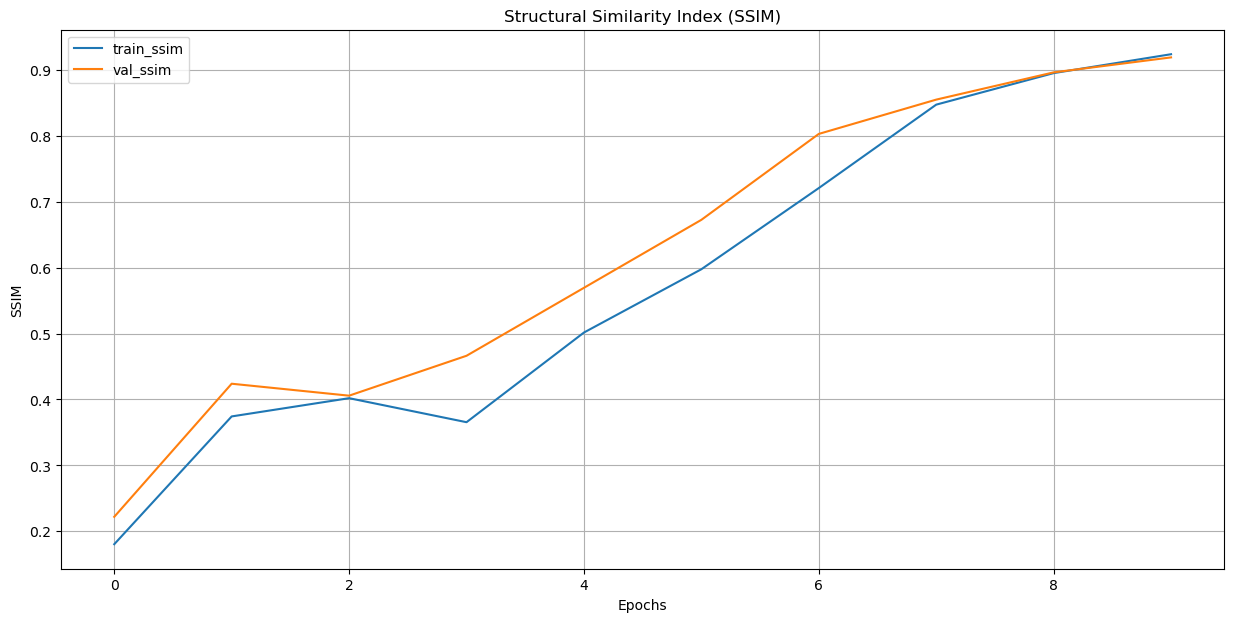

Final Training Loss: 0.0094
Final Validation Loss: 0.0081
Final Training RMSE: 0.0972
Final Validation RMSE: 0.0903
Final Training SSIM: 0.9236
Final Validation SSIM: 0.9187
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step

--- MSE and SSIM for Each Test Image ---
Image 1: MSE = 0.023011, SSIM = 0.817558
Image 2: MSE = 0.035824, SSIM = 0.751735
Image 3: MSE = 0.022001, SSIM = 0.796446
Image 4: MSE = 0.017483, SSIM = 0.843527
Image 5: MSE = 0.030532, SSIM = 0.766358
Image 6: MSE = 0.030796, SSIM = 0.753853
Image 7: MSE = 0.016202, SSIM = 0.857786
Image 8: MSE = 0.015395, SSIM = 0.887588
Image 9: MSE = 0.021672, SSIM = 0.804343
Image 10: MSE = 0.031794, SSIM = 0.754235
Image 11: MSE = 0.023373, SSIM = 0.799068
Image 12: MSE = 0.027328, SSIM = 0.780294
Image 13: MSE = 0.016986, SSIM = 0.836857
Image 14: MSE = 0.027640, SSIM = 0.758512
Image 15: MSE = 0.016469, SSIM = 0.859332
Image 16: MSE = 0.046208, SSIM = 0.796653
Image 17: MSE = 0.015201, SSIM = 0.863835
Image 18: MSE = 0.045544, SSIM = 0.796806
I

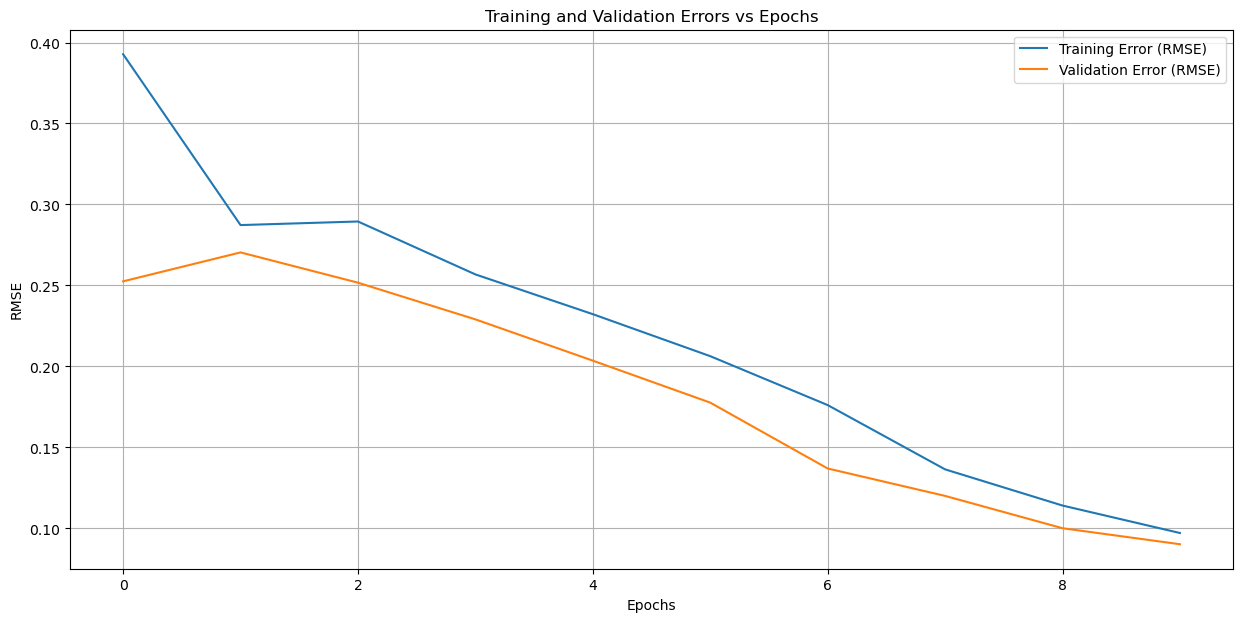

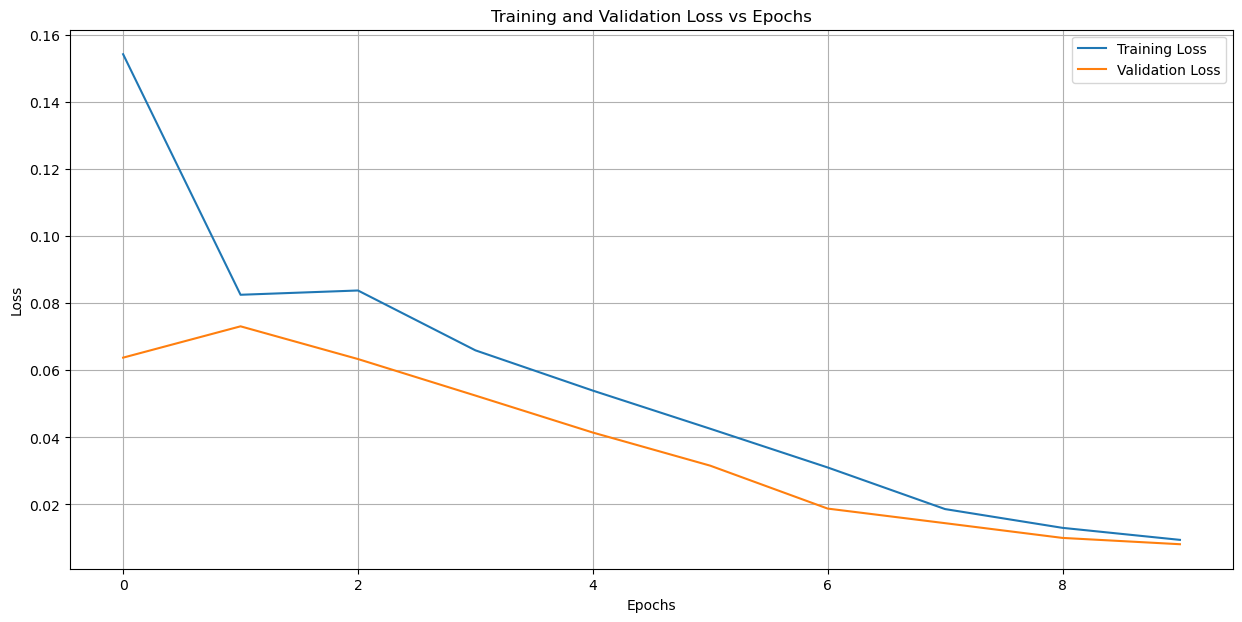


State-of-the-Art Accuracy for This Dataset: 98%


In [ ]:
# Define the model
def build_model():
    model = Sequential()

    # Encoder
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(258, 540, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
    model.add(Conv2DTranspose(16, (3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(),
        ssim])

    return model

# Early stopping to prevent overfitting
es = EarlyStopping(patience=3, restore_best_weights=True)

# Build the model
model = build_model()

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=16,
                    epochs=50,
                    callbacks=[es],
                    verbose=1)

# Plot Training Loss vs. Epochs
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Root Mean Squared Error vs. Epochs
plt.figure(figsize=(15, 7))
plt.plot(history.history['root_mean_squared_error'], label='train_rmse')
plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

# Plot Structural Similarity Index (SSIM) vs. Epochs
plt.figure(figsize=(15, 7))
plt.plot(history.history['ssim'], label='train_ssim')
plt.plot(history.history['val_ssim'], label='val_ssim')
plt.title('Structural Similarity Index (SSIM)')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.grid()
plt.show()

# Display the final metrics after training
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_rmse = history.history['root_mean_squared_error'][-1]
final_val_rmse = history.history['val_root_mean_squared_error'][-1]
final_train_ssim = history.history['ssim'][-1]
final_val_ssim = history.history['val_ssim'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training RMSE: {final_train_rmse:.4f}")
print(f"Final Validation RMSE: {final_val_rmse:.4f}")
print(f"Final Training SSIM: {final_train_ssim:.4f}")
print(f"Final Validation SSIM: {final_val_ssim:.4f}")

# Evaluate MSE and SSIM for each test image
predictions = model.predict(X_test)

# Instantiate the MSE loss object
mse_fn = tf.keras.losses.MeanSquaredError()

print("\n--- MSE and SSIM for Each Test Image ---")
for i in range(len(X_test)):
    true_img = tf.convert_to_tensor(X_test[i])  # Make sure y_test is defined
    pred_img = tf.convert_to_tensor(predictions[i])

    # Add batch dimension
    true_img = tf.expand_dims(true_img, axis=0)
    pred_img = tf.expand_dims(pred_img, axis=0)

    mse = mse_fn(true_img, pred_img).numpy()
    ssim_score = tf.image.ssim(true_img, pred_img, max_val=1.0).numpy().mean()

    print(f"Image {i+1}: MSE = {mse:.6f}, SSIM = {ssim_score:.6f}")

# Track training and testing error (RMSE) over time for graphing
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Training and Testing Errors vs Time (Epochs)
plt.figure(figsize=(15, 7))
plt.plot(train_rmse, label='Training Error (RMSE)')
plt.plot(val_rmse, label='Validation Error (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation Errors vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Training Loss vs Epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 7))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()




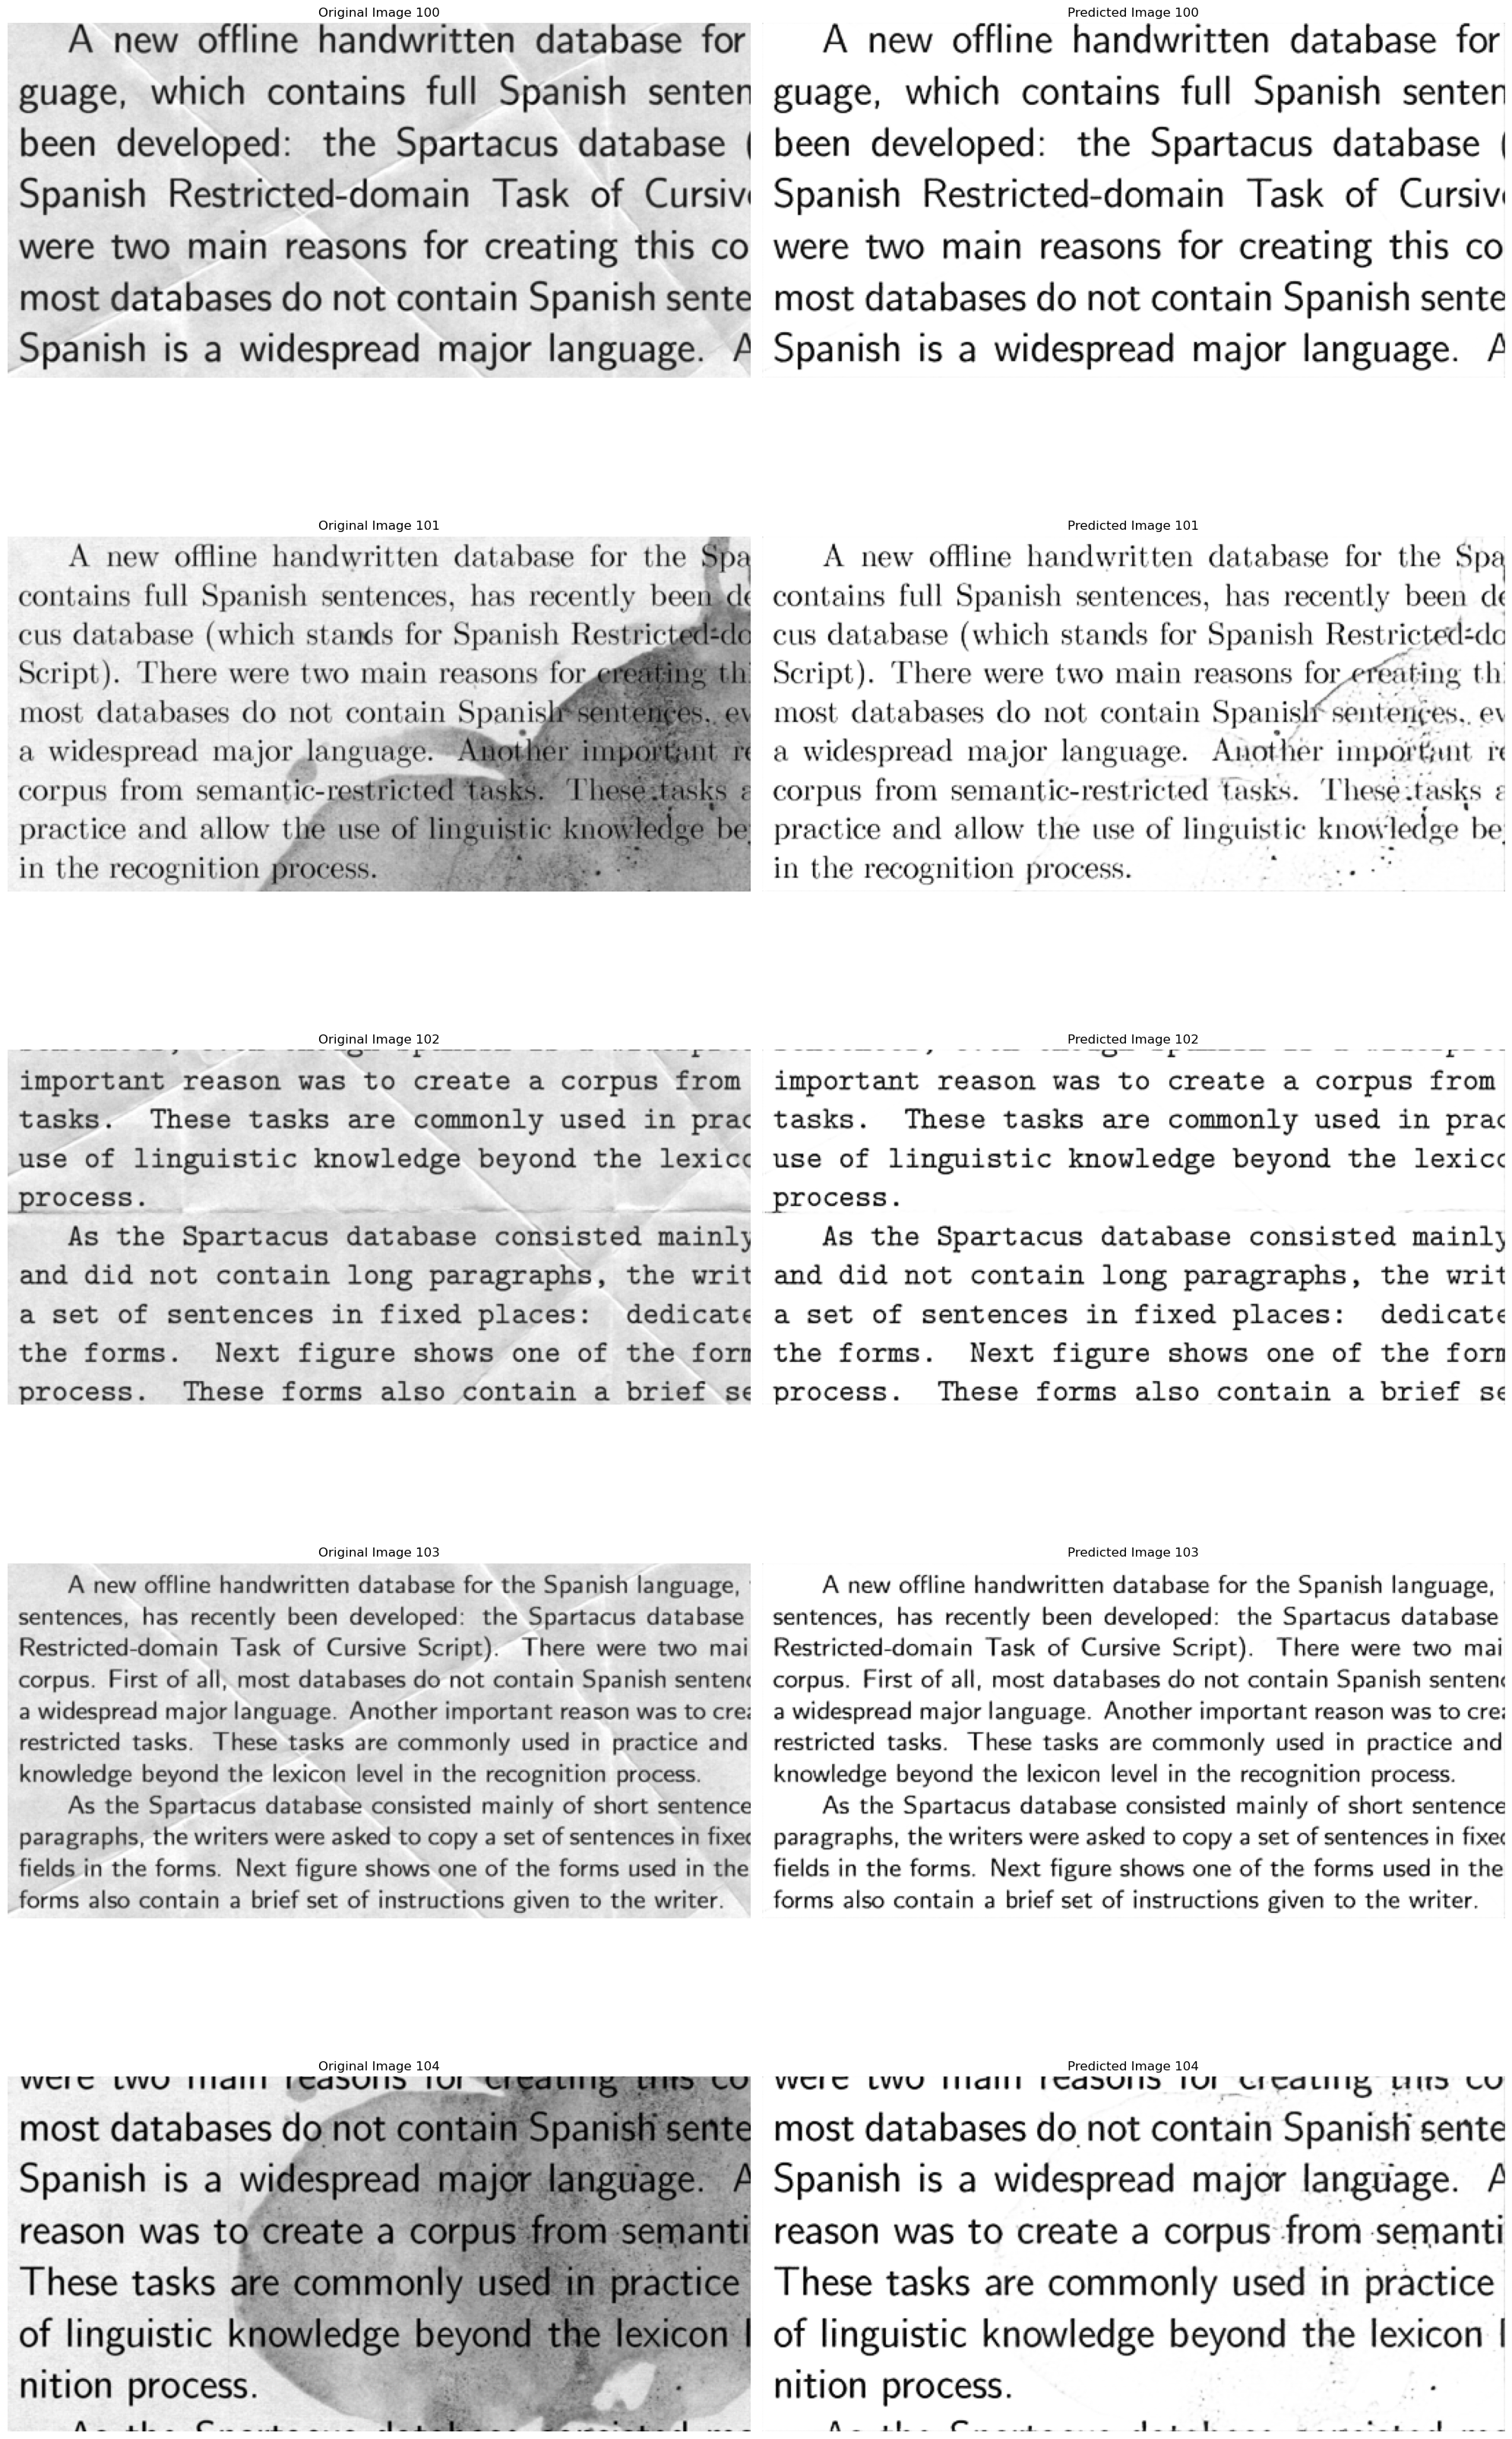

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 2, figsize=(20, 35))


for i in range(5):
    ax[i, 0].imshow(X_test[100 + i], cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Original Image {100 + i}')

for i in range(5):
    ax[i, 1].imshow(y_pred[100 + i], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title(f'Predicted Image {100 + i}')
plt.tight_layout()
plt.show()